## Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import netCDF4
import xarray as xr
from scipy.stats import pearsonr, linregress
from scipy import signal
import cartopy.crs as ccrs
import xskillscore as xs

## Some Useful Functions

In [3]:
def weighted_temporal_mean(ds):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

In [4]:
def regional_subset(ds, lon_bnds, lat_bnds, lon_name, lat_name):
    if lon_bnds[0]<lon_bnds[1]:
        subset = ds.where((ds[lon_name] > lon_bnds[0]) & (ds[lon_name] < lon_bnds[1]) & 
                         (ds[lat_name] > lat_bnds[0]) & (ds[lat_name] < lat_bnds[1]), drop=True)
    else:
        subset = ds.where(((ds[lon_name] > lon_bnds[0]) | (ds[lon_name] < lon_bnds[1])) & 
                 (ds[lat_name] > lat_bnds[0]) & (ds[lat_name] < lat_bnds[1]), drop=True)
    return subset

## Data

In [6]:
humboldt_MW = xr.open_dataarray('mw_hum_regridded.nc')

In [7]:
humboldt_O2 = xr.open_dataarray('Humboldt_O2min_regridded.nc')

In [8]:
humboldt_MW_south = humboldt_MW.sel(lat=slice(-45, -30))
humboldt_O2_south = humboldt_O2.sel(lat=slice(-45, -30))

In [9]:
humboldt_MW = weighted_temporal_mean(humboldt_MW)
humboldt_MW_south = weighted_temporal_mean(humboldt_MW_south)
humboldt_O2 = weighted_temporal_mean(humboldt_O2)
humboldt_O2_south = weighted_temporal_mean(humboldt_O2_south)


/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_en

In [10]:
humboldt_O2_mean = humboldt_O2_south.mean(dim=('lat','lon'))
humboldt_MW_mean = humboldt_MW_south.mean(dim=('lat','lon'))

In [11]:
humboldt_full = xr.open_dataarray('Humboldt_O2full_regridded.nc')

humboldt_full = weighted_temporal_mean(humboldt_full)

/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(


## Finding Volumes

In [12]:
def find_volume(region, threshold):
    vol = xr.where(region<=threshold, 1, 0)
    vol = vol.transpose('z_t','time','lat','lon')

    width = 111000*np.cos(np.deg2rad(30))
    length = 111000
    for i, depth in enumerate(vol):
        if i == 0:
            height = (vol.z_t[0]*2).values
        elif i == len(vol)-1:
            height = (vol.z_t[i]-vol.z_t[i-1]).values
        else:
            height = ((vol.z_t[i+1]-vol.z_t[i-1])/2).values
        vol[i] = width*length*height*depth
    return vol.sum(dim=('lat','lon','z_t'))

In [13]:
humboldt_vol_45 = find_volume(humboldt_full, 45)

humboldt_vol_20 = find_volume(humboldt_full, 20)

humboldt_vol_60 = find_volume(humboldt_full, 60)

In [14]:
humboldt_O2min = humboldt_O2.sel(lat=slice(-45,-15)).mean(dim=('lat','lon'))

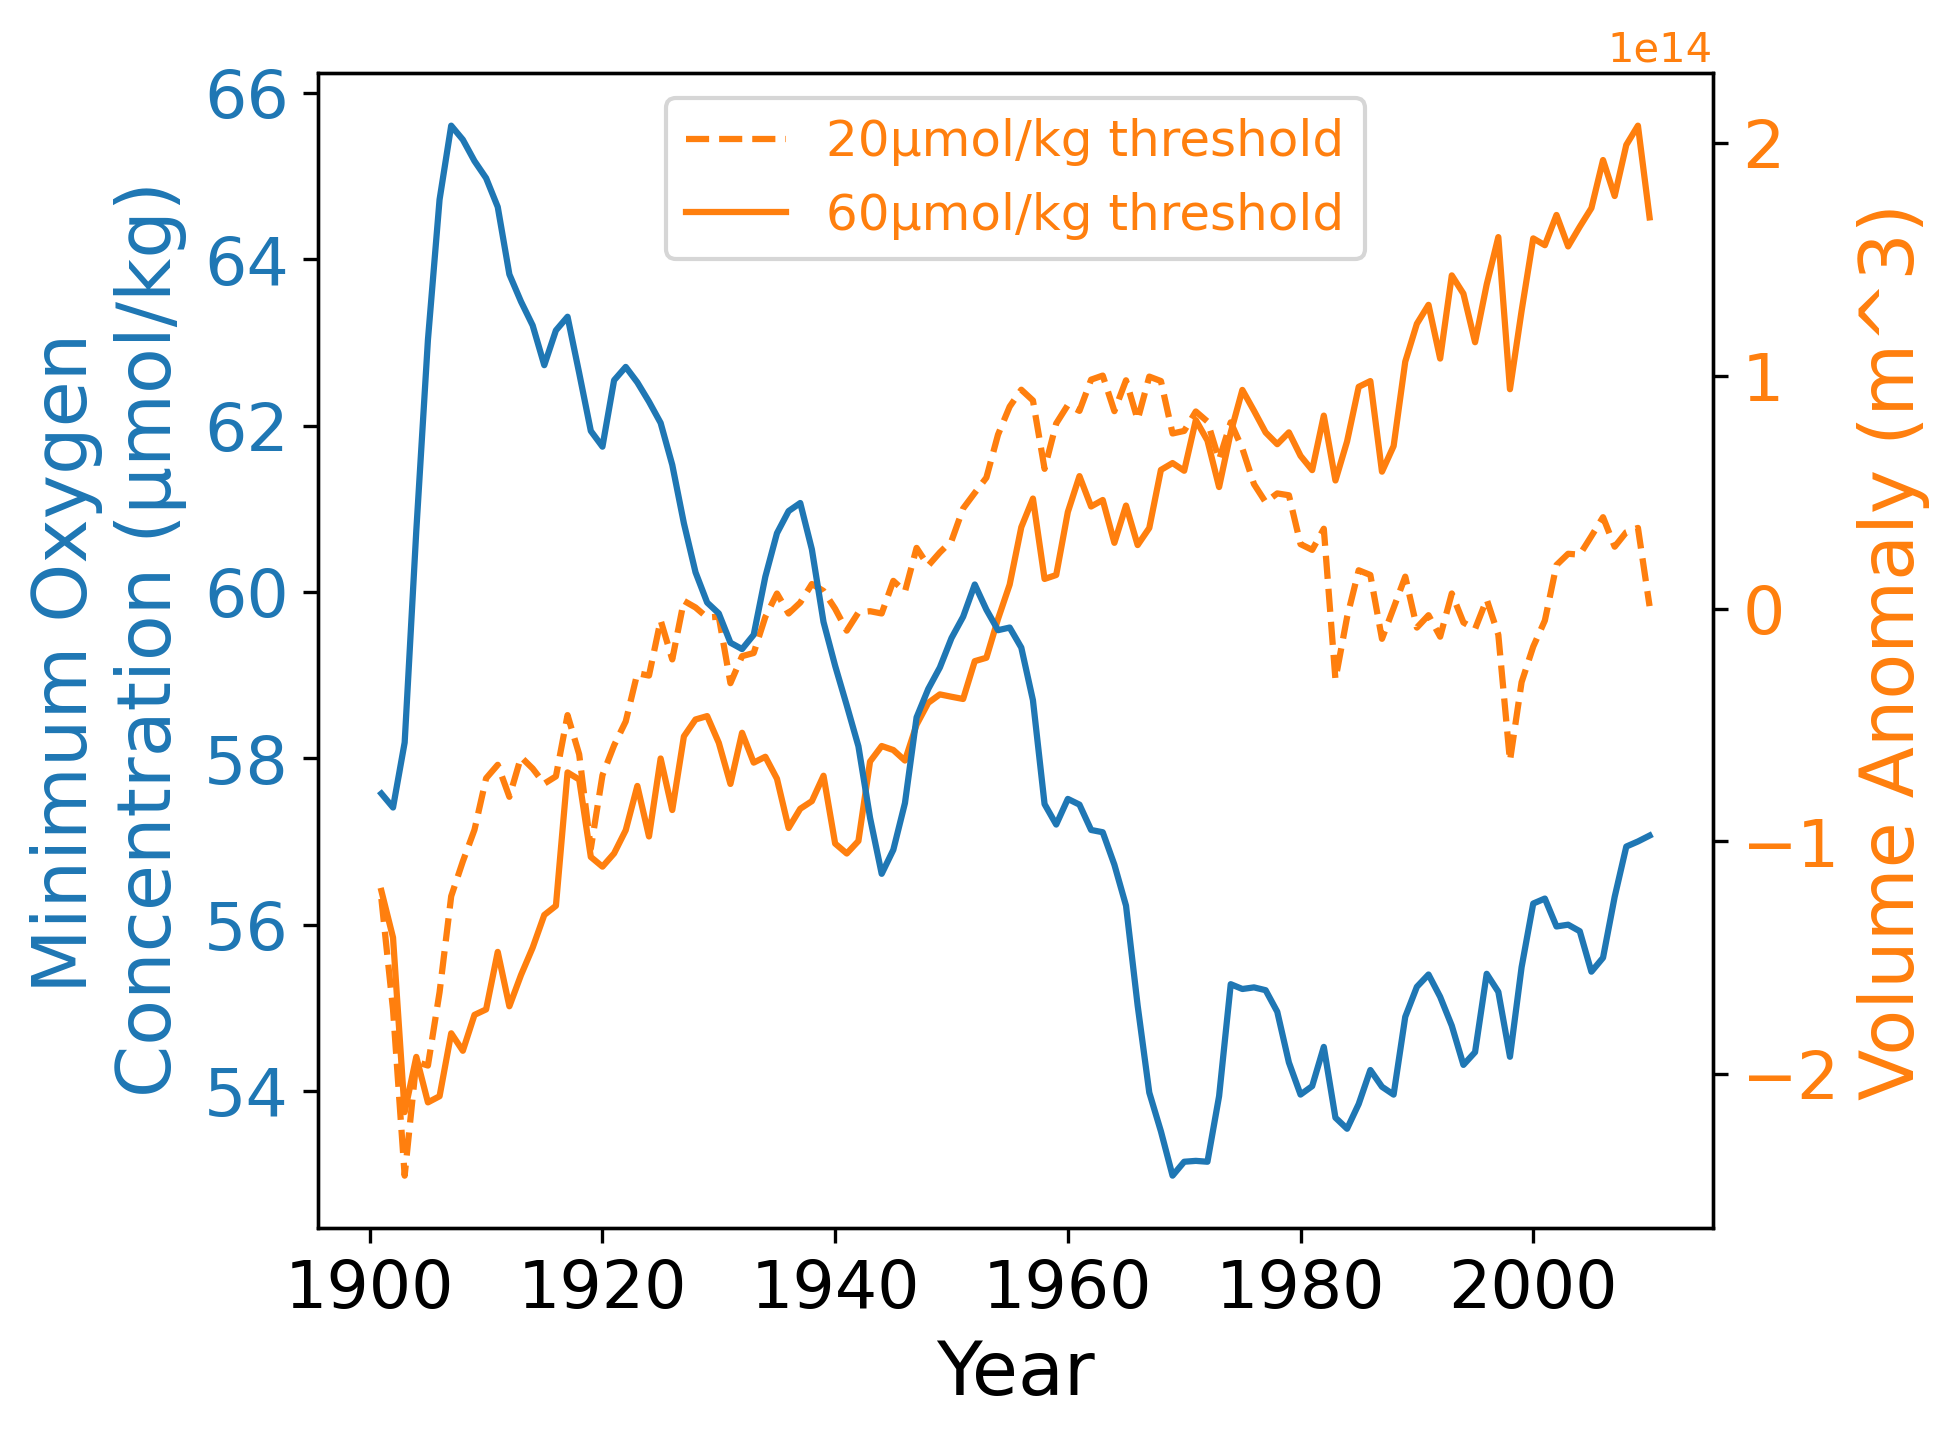

In [15]:
fig, ax = plt.subplots(figsize=(6,5), dpi=300)

ax.plot(humboldt_O2min['time.year'], humboldt_O2min, color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.set_ylabel('Minimum Oxygen \n Concentration (μmol/kg)', color='tab:blue', fontsize=18)
ax.set_xlabel('Year', fontsize=18)
ax2 = ax.twinx()
# ax2.plot(humboldt_O2['time.year'], humboldt_vol-humboldt_vol.mean(), color='tab:red')
# ax2.fill_between(humboldt_O2['time.year'], humboldt_vol_20-humboldt_vol_20.mean(), 
#                  humboldt_vol_60-humboldt_vol_60.mean(), color='tab:orange', alpha=0.3)
# ax2.plot(humboldt_O2['time.year'], humboldt_vol_45-humboldt_vol_45.mean(), color='tab:orange')
ax2.plot(humboldt_O2['time.year'], humboldt_vol_20-humboldt_vol_20.mean(), color='tab:orange', linestyle='--', 
         label = '20µmol/kg threshold')
ax2.plot(humboldt_O2['time.year'], humboldt_vol_60-humboldt_vol_60.mean(), color='tab:orange', 
         label = '60µmol/kg threshold')
ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=16)
ax2.set_ylabel('Volume Anomaly (m^3)', color='tab:orange', fontsize=18)

ax2.legend(loc='upper center', fontsize=12, labelcolor='tab:orange')

ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
ax2.patch.set_visible(True)

fig.patch.set_fill(False)
plt.show()

In [16]:
fit = humboldt_O2.polyfit(dim='time', deg=1).sel(degree=1)['polyfit_coefficients']

In [17]:
variance = humboldt_O2.var(dim='time')

In [18]:
def linregress_wrapper(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

fit = xr.apply_ufunc(linregress_wrapper, humboldt_O2['time.year'].values, humboldt_O2, 
                        input_core_dims=[['time'], ['time']], output_core_dims=[['stat']], 
                        vectorize=True, dask='parallelized', output_dtypes=[float])

stat_labels = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']
fit = fit.assign_coords(stat=stat_labels)

In [19]:
indices = np.argwhere(fit.sel(stat='p_value').values<0.01)
x = fit.lon[indices[:,1]]
y = fit.lat[indices[:,0]]

In [20]:
humboldt_O2_early_period = humboldt_O2.sel(time=slice(None,'1965'))
humboldt_O2_late_period = humboldt_O2.sel(time=slice('1965',None))

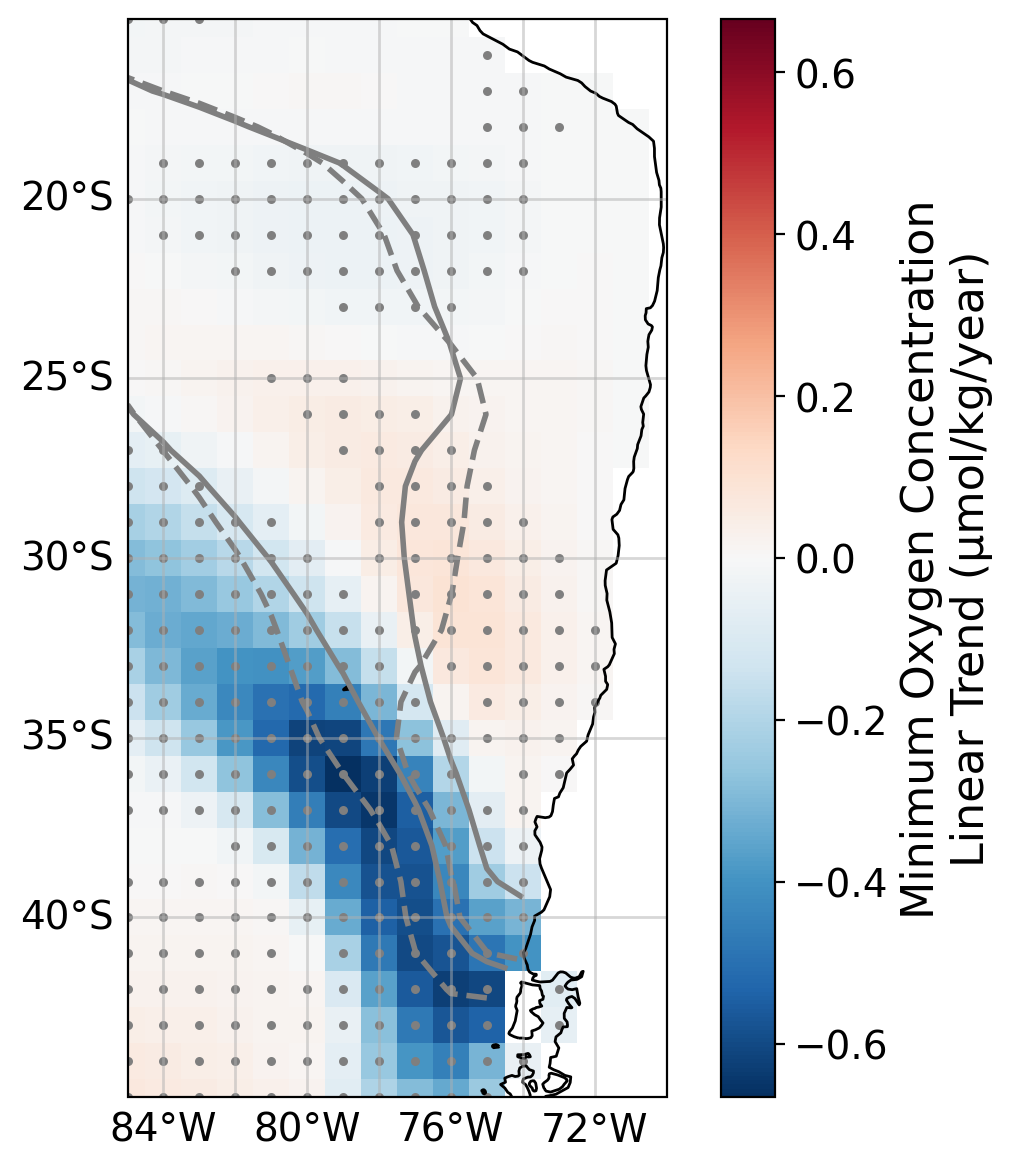

In [43]:
plt.figure(figsize=(7, 7), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())

pc = fit.sel(stat='slope').plot(ax=ax)
pc.colorbar.ax.set_ylabel('Minimum Oxygen Concentration\nLinear Trend (µmol/kg/year)', fontsize=16)
pc.colorbar.ax.tick_params(labelsize=14)

ax.scatter(x, y, color='tab:gray', s=5)

# variance.plot.contour(ax=ax, levels=9, colors='tab:gray', alpha=0.8)
# humboldt_O2.mean('time').plot.contour(ax=ax, levels=[20], colors='tab:gray', alpha=0.8)
ax.contour(humboldt_O2_early_period.lon, humboldt_O2_early_period.lat, humboldt_O2_early_period.mean('time'), 
           levels=[20, 60], colors='tab:gray', alpha=1, linewidths=2)
ax.contour(humboldt_O2_late_period.lon, humboldt_O2_late_period.lat, humboldt_O2_late_period.mean('time'), 
           linestyles='--', levels=[20, 60], colors='tab:gray', alpha=1, linewidths=2)

ax.coastlines()
ax.set_extent([275, 290, -15, -45])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=.5, linewidth=1)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size':14}
gl.ylabel_style = {'size':14}
plt.title(None)

plt.show()

## Correlation between northern and southern portions of region

In [44]:
humboldt_O2N = humboldt_O2.sel(lat=slice(-30, -15))

In [45]:
humboldt_O2N_ts = xr.apply_ufunc(signal.detrend, humboldt_O2N.mean(dim=('lat','lon')))

In [46]:
humboldt_O2S = humboldt_O2.sel(lat=slice(-40, -30))

In [48]:
humboldt_O2S_ts = xr.apply_ufunc(signal.detrend, humboldt_O2S.mean(dim=('lat','lon')))

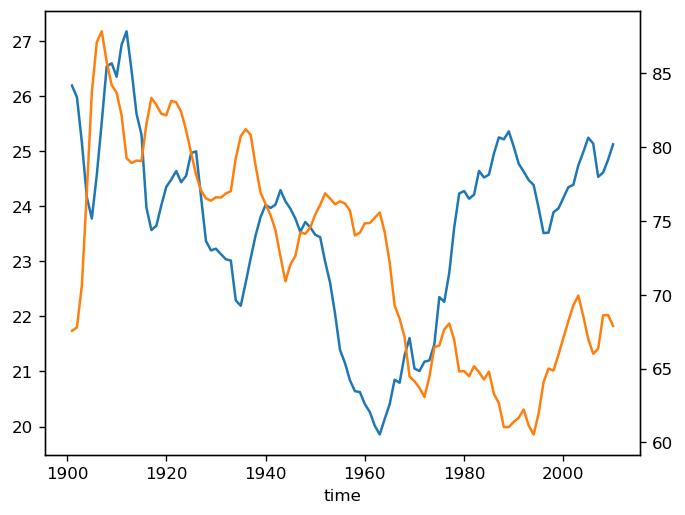

In [49]:
fig, ax = plt.subplots(1, dpi=120)

humboldt_O2N.mean(dim=('lat','lon')).plot(ax=ax)
ax2 = ax.twinx()
humboldt_O2S.mean(dim=('lat','lon')).plot(ax=ax2, color='tab:orange')
plt.show()

In [51]:
xs.pearson_r(humboldt_O2N_ts, humboldt_O2S_ts)

<xarray.DataArray ()> Size: 8B
array(-0.12427648)

In [52]:
xs.pearson_r_eff_p_value(humboldt_O2N_ts, humboldt_O2S_ts)

<xarray.DataArray ()> Size: 8B
array(0.84217453)

## Splitting North/South

In [53]:
humboldt_full_S = humboldt_full.sel(lat=slice(-45, -33))
humboldt_full_N = humboldt_full.sel(lat=slice(-33, -15))

In [54]:
humboldt_vol_20S = find_volume(humboldt_full_S, 20)[5:]
humboldt_vol_20N = find_volume(humboldt_full_N, 20)[5:]

humboldt_vol_60S = find_volume(humboldt_full_S, 60)[5:]
humboldt_vol_60N = find_volume(humboldt_full_N, 60)[5:]

In [55]:
humboldt_O2min_S = humboldt_O2.sel(lat=slice(-45, -33)).mean(dim=('lat','lon'))[5:]
humboldt_O2min_N = humboldt_O2.sel(lat=slice(-33, -15)).mean(dim=('lat','lon'))[5:]

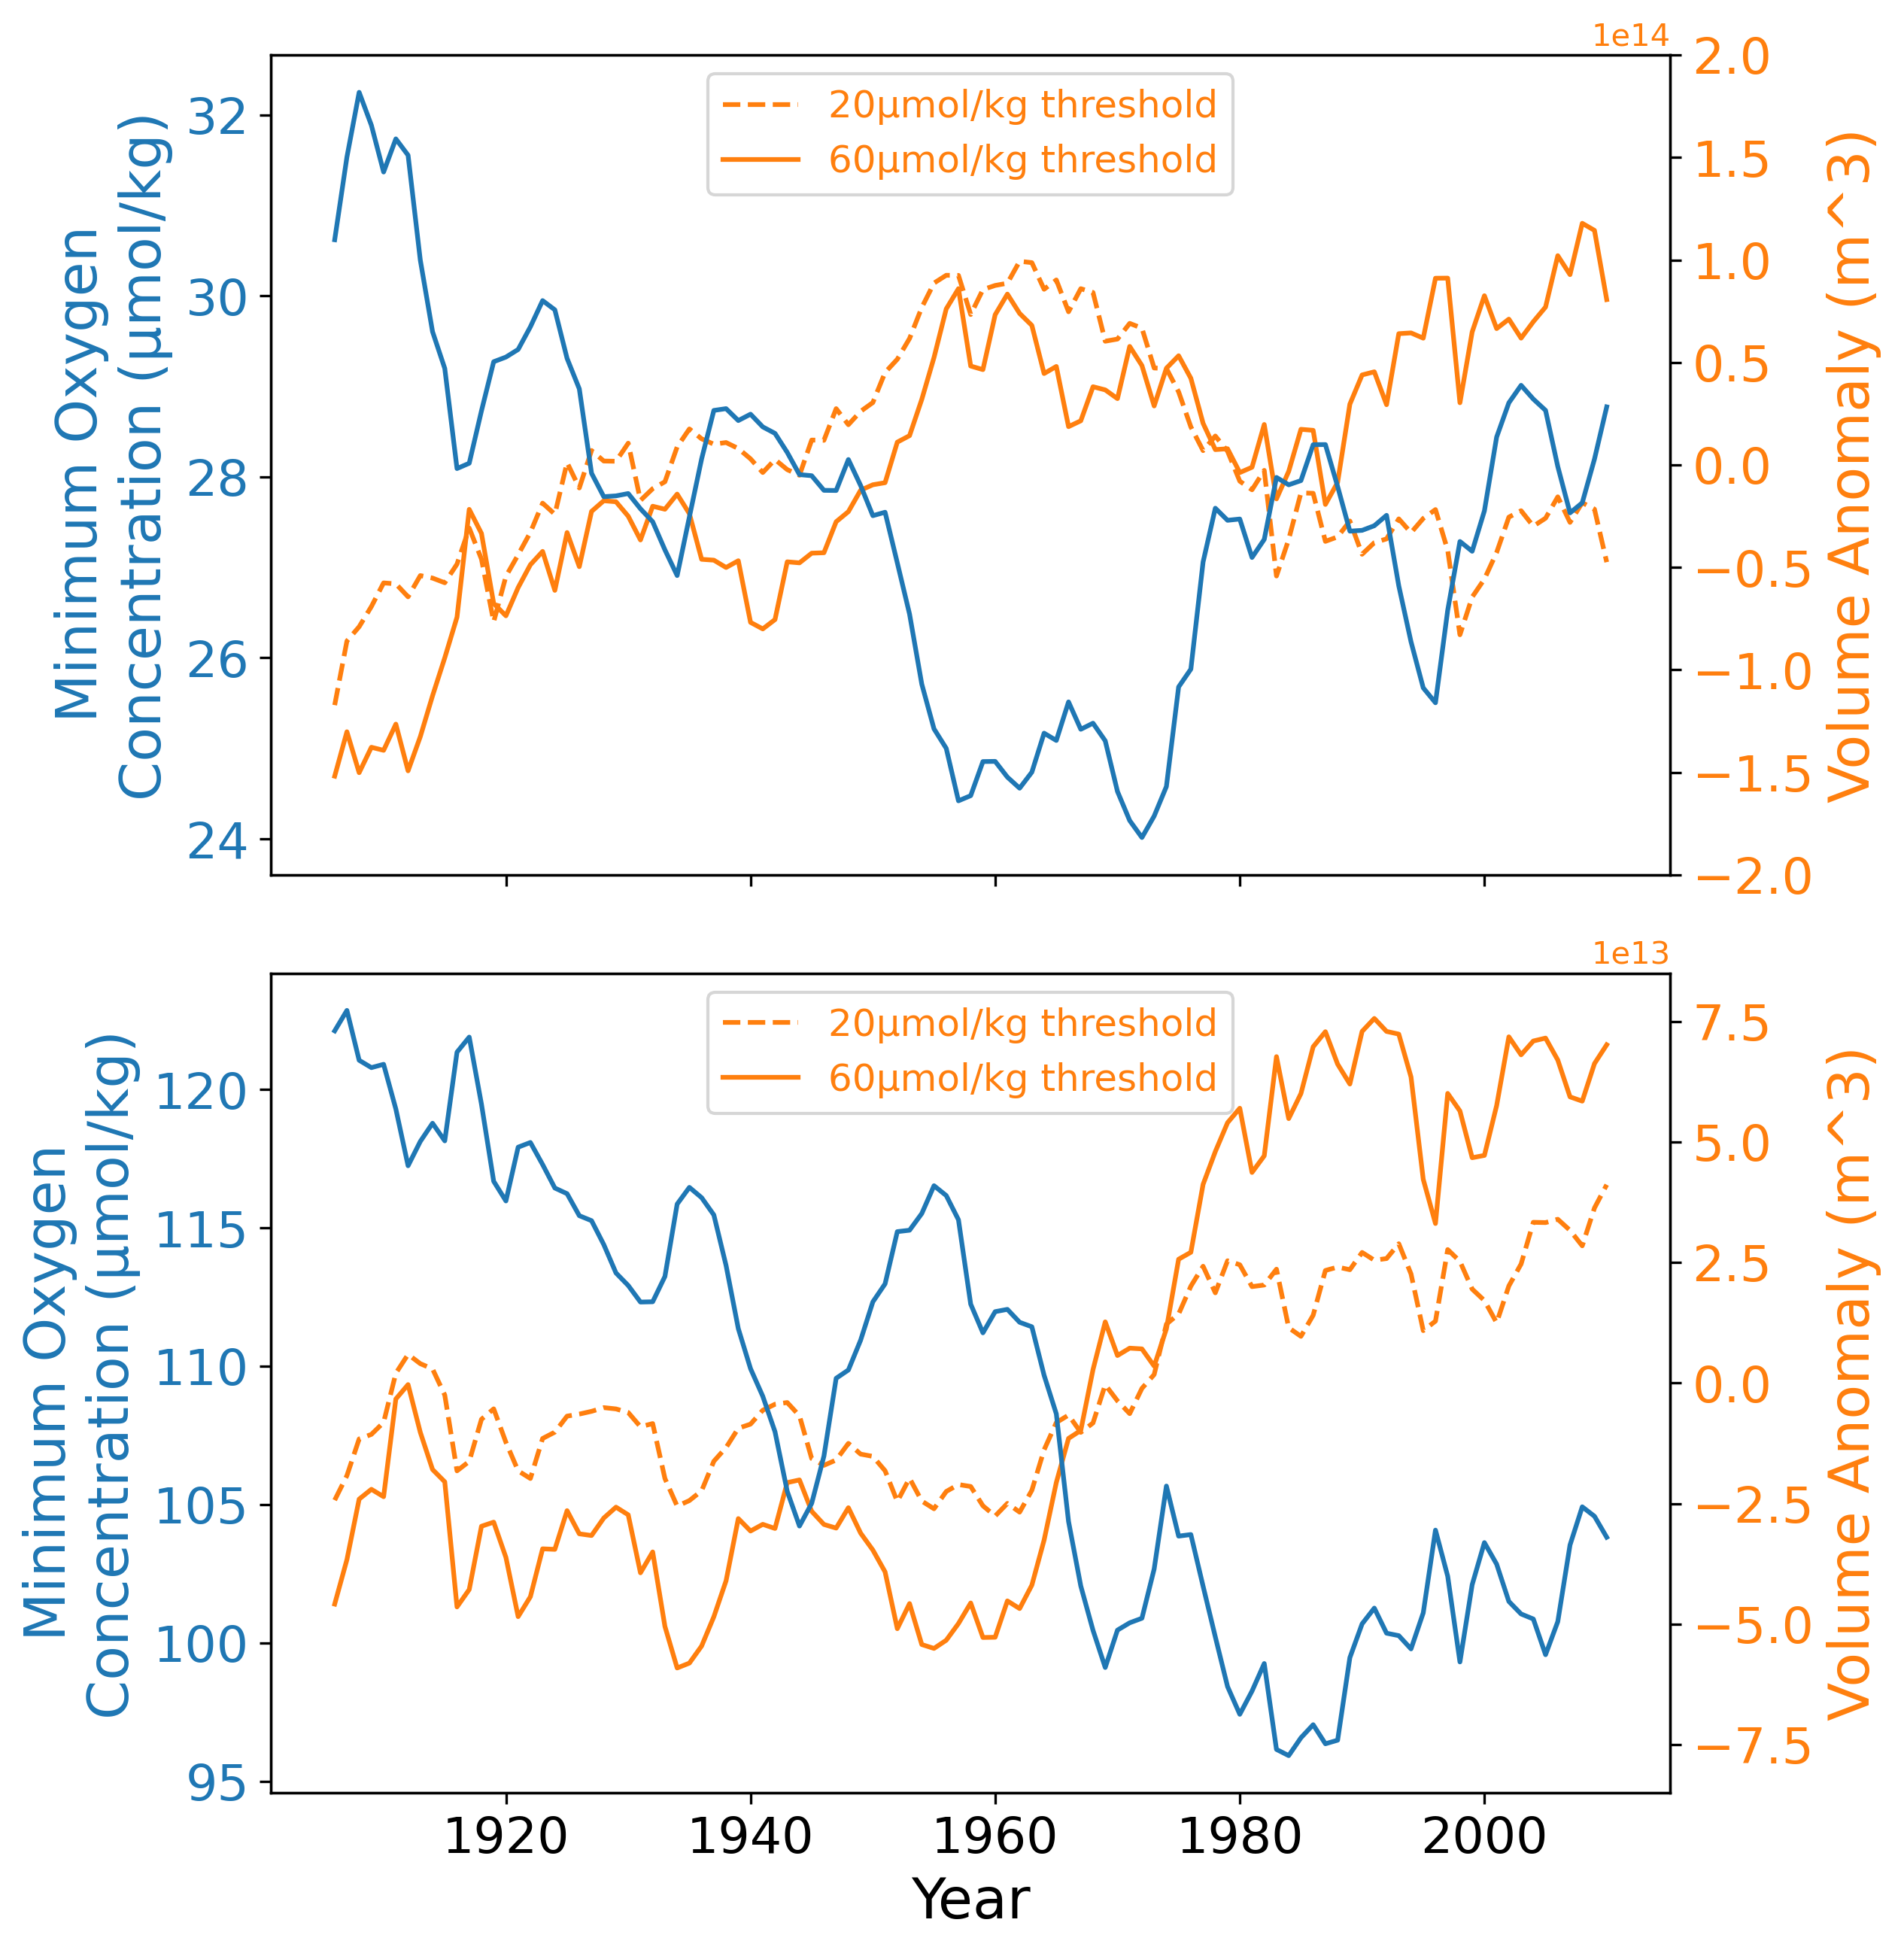

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(8,10), sharex=True, dpi=300)

ax[0].plot(humboldt_O2min_N['time.year'], humboldt_O2min_N, color='tab:blue')
ax[0].tick_params(axis='y', labelcolor='tab:blue', labelsize=16)
ax[0].tick_params(axis='x', labelsize=16)
ax[0].set_ylabel('Minimum Oxygen \n Concentration (μmol/kg)', color='tab:blue', fontsize=18)

ax2 = ax[0].twinx()
ax2.plot(humboldt_vol_20N['time.year'], humboldt_vol_20N-humboldt_vol_20N.mean(), color='tab:orange', linestyle='--', 
         label = '20µmol/kg threshold')
ax2.plot(humboldt_vol_20N['time.year'], humboldt_vol_60N-humboldt_vol_60N.mean(), color='tab:orange', 
         label = '60µmol/kg threshold')
ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=16)
ax2.set_ylabel('Volume Anomaly (m^3)', color='tab:orange', fontsize=18)
ax2.set_ylim([-2e14,2e14])

ax2.legend(loc='upper center', fontsize=12, labelcolor='tab:orange')

ax[0].set_zorder(ax2.get_zorder()+1)
ax[0].patch.set_visible(False)
ax2.patch.set_visible(True)

ax[1].plot(humboldt_O2min_S['time.year'], humboldt_O2min_S, color='tab:blue')
ax[1].tick_params(axis='y', labelcolor='tab:blue', labelsize=16)
ax[1].tick_params(axis='x', labelsize=16)
ax[1].set_ylabel('Minimum Oxygen \n Concentration (μmol/kg)', color='tab:blue', fontsize=18)
ax[1].set_xlabel('Year', fontsize=18)

ax2 = ax[1].twinx()
ax2.plot(humboldt_vol_20N['time.year'], humboldt_vol_20S-humboldt_vol_20S.mean(), color='tab:orange', linestyle='--', 
         label = '20µmol/kg threshold')
ax2.plot(humboldt_vol_20N['time.year'], humboldt_vol_60S-humboldt_vol_60S.mean(), color='tab:orange', 
         label = '60µmol/kg threshold')
ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=16)
ax2.set_ylabel('Volume Anomaly (m^3)', color='tab:orange', fontsize=18)
ax2.set_ylim([-8.5e13,8.5e13])

# ax2.axvline(1965)

ax2.legend(loc='upper center', fontsize=12, labelcolor='tab:orange')

ax[1].set_zorder(ax2.get_zorder()+1)
ax[1].patch.set_visible(False)
ax2.patch.set_visible(True)

plt.subplots_adjust(hspace=0.12)

fig.patch.set_fill(False)
plt.show()